<div align="center">
<font size="5">__cta-lstchain: Notebook for testing the effects of impact parameters on the energy reconstruction__</font>
    
<font size="4">
To run this notebook you will need the last version of cta-lstchain:

git clone https://github.com/cta-observatory/cta-lstchain
<br>
<br>
**If you have ctapipe already installed in a conda environment:**
<br><br>
source activate cta-dev
<br>
python setup.py install
<br>
<font size="4">
**If you don't have ctapipe installed:**</font>
<br><br>
conda env create -f environment.yml
<br>
source activate cta-dev
<br>
python setup.py install

Also, you will need the datafiles from **cta-lstchain-extra:**

git clone https://github.com/misabelber/cta-lstchain-extra


<font size="4">
**Some imports...**

In [1]:
import numpy as np                                                                                            
import pandas as pd                                                                                                                                                                                      
import matplotlib.pyplot as plt                                                                                                                                                             
from lstchain.reco import reco_dl1_to_dl2     
from lstchain.visualization import plot_dl2                                                                   
from lstchain.reco import utils
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 14

<font size="4">
**Get event DL1 file for training.**
<br>
Gammas are pointlike.

In [2]:
try:
    PATH_EVENTS = "/home/queenmab/DATA/LST1/Events"
    gammafile = PATH_EVENTS+"/gamma_events_point.h5"

except:

    PATH_EVENTS = "../../cta-lstchain-extra/reco/sample_data/dl1/"
    gammafile = PATH_EVENTS+"/gamma_events_point_tiny.h5"

<font size="4">
We read the file as pandas dataframes:

In [3]:
df_gammas = pd.read_hdf(gammafile)                                                               
df_gammas.keys()

Index(['obs_id', 'event_id', 'mc_energy', 'mc_alt', 'mc_az', 'mc_core_x',
       'mc_core_y', 'mc_h_first_int', 'mc_type', 'gps_time', 'width', 'length',
       'wl', 'phi', 'psi', 'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis',
       'mc_alt_tel', 'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient',
       'intercept', 'src_x', 'src_y', 'disp', 'hadroness'],
      dtype='object')

<font size="4">
Energy should be proportional to intensity:

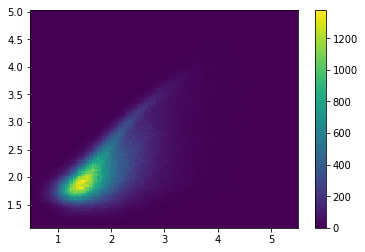

In [4]:
h = plt.hist2d(df_gammas['mc_energy'],df_gammas['intensity'],bins=100)
plt.colorbar(h[3])

<font size="4">
Let's choose events with a closer impact parameter (>40m, <100m)

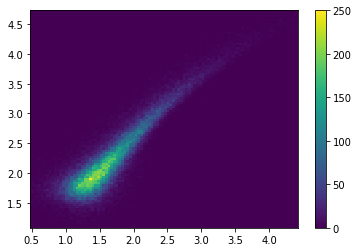

In [5]:
closer = df_gammas[df_gammas["impact"]>40]
closer = closer[closer["impact"]<100]
c = plt.hist2d(closer['mc_energy'],closer['intensity'],bins=100)
plt.colorbar(c[3])

<font size="4">
Correlation is much more clear for this range. 
<br><br>
Let's see how this cut affect to the energy reconstruction.
<br><br>
First of all, let's train a Random Forest with all events, **without any cut** and without using any mc information.
<br>
Choose the features for training the random forest (Hillas and Timing parameters) 

In [6]:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi',
            'skewness',
            'kurtosis']

<font size="4">
Split data into train and test sets.

In [7]:
np.random.seed(0)
train,test = reco_dl1_to_dl2.split_traintest(df_gammas,0.5)

<font size="4">
And train Random Forests for Energy and Disp reconstruction.

In [8]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train,features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis']
Number of events for training:  266662
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp Reconstruction...
Random Forest trained!
Done!


<font size="4">
Apply RF to test data to reconstruct Energy.

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


-0.06726932782778344 0.6023056006632599


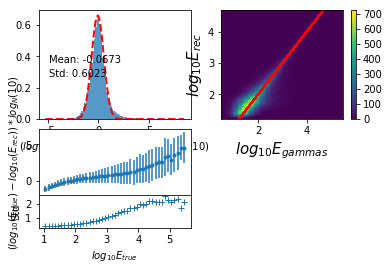

In [9]:
test['e_rec'] = RFreg_Energy.predict(test[features])
plot_dl2.plot_e(test,True)

<font size="4">
The error is 60%.
<br>
<br>
    Now, lets do the cuts on impact parameter to have closer events.

In [10]:
train_cut = train[train["impact"]>40]
train_cut = train_cut[train_cut["impact"]<100]
test_cut = test[test["impact"]>40]
test_cut = test_cut[test_cut["impact"]<100]

<font size="4">
    Train the RF again.

In [11]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train_cut,features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis']
Number of events for training:  33646
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp Reconstruction...
Random Forest trained!
Done!


<font size="4">
    And reconstruct the energy.

0.007896911273758609 0.4129869773765044


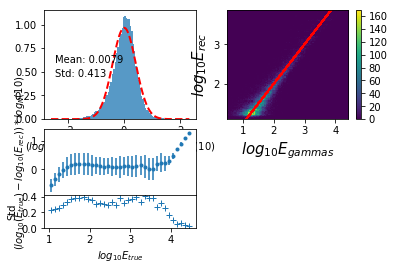

In [12]:
test_cut['e_rec'] = RFreg_Energy.predict(test_cut[features])
plot_dl2.plot_e(test_cut,True)

<font size="4">
    Now the error is 41%.
    <br>
    <br>
    Let's do a last test. We will use all events, but using the impact parameter as a feature.

In [13]:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi',
            'skewness',
            'kurtosis',
            'impact']

<font size="4">
And train Random Forests for Energy and Disp reconstruction.

In [14]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train,features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis', 'impact']
Number of events for training:  266662
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp Reconstruction...
Random Forest trained!
Done!


<font size="4">
Apply RF to test data to reconstruct Energy.

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.01019218076987277 0.4635810559983711


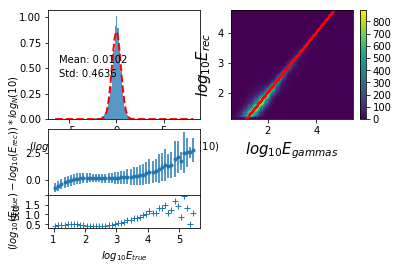

In [15]:
test['e_rec'] = RFreg_Energy.predict(test[features])
plot_dl2.plot_e(test,True)

<font size="4">
    Now the error is 46%.
    <br>
    <br>